In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from joblib import dump, load
from skimage import color
import imageio.v2 as imageio
from skimage.transform import resize
from skimage.feature import hog
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa


from PIL import Image
%matplotlib inline

# Get the directory path
train_directory_path = "./train_ims"
test_directory_path = "./test_ims"

# List filenames in alphabetical order
train_filenames = sorted(os.listdir(train_directory_path))
test_filenames  = sorted(os.listdir(test_directory_path))


In [3]:
#augmentation function
aug = iaa.Sequential([
    iaa.Fliplr(0.5),  # Flip horizontally with 50% probability
    iaa.Flipud(0.5),  # Flip vertically with 50% probability
    iaa.Affine(rotate=(-10, 10)),  # Random rotation
    iaa.GaussianBlur(sigma=(0.0, 0.3)),  # Apply Gaussian blur with a sigma between 0 and 0.5
])

In [4]:
#train_test split
x_train = []
x_test = []
x_valid = []

y_train = []
y_test = []
y_valid = []


train_df = pd.read_csv("train.csv") 
test_df = pd.read_csv("test.csv")

#48,000 for training split, 2,000 for validation set, 10000 for testing split
for i in range(50000):
    image = imageio.imread(f"{train_directory_path}/{train_filenames[i]}")

    if i < 45000:
        x_train.append(image)
        y_train.append(train_df["label"].iloc[i])
    else:
        x_valid.append(image)
        y_valid.append(train_df["label"].iloc[i])


for j in range(10000):
    image = imageio.imread(f"{test_directory_path}/{test_filenames[j]}")
    x_test.append(image)

x_train = np.array(x_train)
x_test = np.array(x_test)
x_valid = np.array(x_valid)

#pick 10,000 images for augmentation set
augmented_images = aug(images=x_train[15000:25000])
augmented_labels = y_train[15000:25000]


x_train = np.concatenate((x_train, augmented_images))

y_train = np.concatenate((np.array(y_train), np.array(augmented_labels)))
y_test = np.array(test_df["label"].to_numpy())
y_valid = np.array(y_valid)

#assertions
assert x_train.shape == (55000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert x_valid.shape == (5000, 32, 32, 3)

y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

assert y_train.shape == (55000,)
assert y_test.shape == (10000,)
assert y_valid.shape == (5000, )


In [5]:
#function for feature extraction via SIFT
def get_sift_feature(im):
    gray_im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    _, descriptors = sift.detectAndCompute((gray_im * 255).astype("uint8"), None)
    if descriptors is None:
        return np.zeros((128,))
    return np.mean(descriptors, axis=0) 

#function for feature extraction via HOG
def get_hog_feature(im):
    gray_im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    hog_features = hog(gray_im, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
    hsv_image = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

    hist_features = []
    for channel in cv2.split(hsv_image):
        hist_features.append(cv2.calcHist([channel], [0], None, [8], [0, 256]))
    hist_features = np.concatenate(hist_features).flatten() / (image.shape[0] * image.shape[1])
    return np.concatenate((hog_features, hist_features))

#function for feature extraction via EOH
def get_eoh_features(image, num_bins=16):

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grad_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
    grad_mag, grad_dir = cv2.cartToPolar(grad_x, grad_y, angleInDegrees=True)

    grad_dir_bins = np.floor(grad_dir / (360 / num_bins)).astype(np.int32)

    eoh_hist = np.zeros(num_bins, dtype=np.float32)
    for i in range(num_bins):
        eoh_hist[i] = np.sum(grad_mag[grad_dir_bins == i])

    eoh_hist /= np.sum(eoh_hist)
    return eoh_hist

#function that combines the features extracted from all 3 of the previous methods
def sift_hog_combined_features(im):
    hog_features = get_hog_feature(im)
    sift_features = get_sift_feature(im)
    eoh_features = get_eoh_features(im)
    combined_features = np.concatenate((hog_features, eoh_features, sift_features), axis=0)
    return combined_features

In [6]:
sift_hog_features_train = []
sift_hog_features_test = []
sift_hog_features_valid = []

#applying feature extraction to the numpy images
for image1 in x_train:
    sift_hog_features_train.append(sift_hog_combined_features(image1))

for image2 in x_test:
    sift_hog_features_test.append(sift_hog_combined_features(image2))

for image3 in x_valid:
    sift_hog_features_valid.append(sift_hog_combined_features(image3))

sift_hog_features_train = np.array(sift_hog_features_train)
sift_hog_features_test = np.array(sift_hog_features_test)
sift_hog_features_valid = np.array(sift_hog_features_valid)

In [7]:
#checking for number of components after applying PCA(0.99)
pca2 = PCA(0.99)
pca2.fit(sift_hog_features_train)
print(pca2.n_components_)

104


In [8]:
#setting up the pipeline framework incorporating feature scaling, dimensionality reduction, and use of optimized RBF SVM
pipe = Pipeline([('StandardScaler', MinMaxScaler()), ('pca', PCA(0.99)), ('rbfsvc', SVC(kernel='rbf', C=1.9, cache_size=10000))])

#fitting the train set to the pipeline
pipe.fit(sift_hog_features_train, y_train)

Pipeline(steps=[('StandardScaler', MinMaxScaler()),
                ('pca', PCA(n_components=0.99)),
                ('rbfsvc', SVC(C=1.9, cache_size=10000))])

In [9]:
dump(pipe, 'pipe.joblib')
pipe = load('pipe.joblib')

#checking for accuracy on the validation set
print(pipe.score(sift_hog_features_valid, y_valid))
y_pred_valid = pipe.predict(sift_hog_features_valid)

#updating the test file by predicting on the test_set
y_pred_test= pipe.predict(sift_hog_features_test)

test_df["label"] = y_pred_test
test_df.to_csv("test.csv", index=False)

0.6814


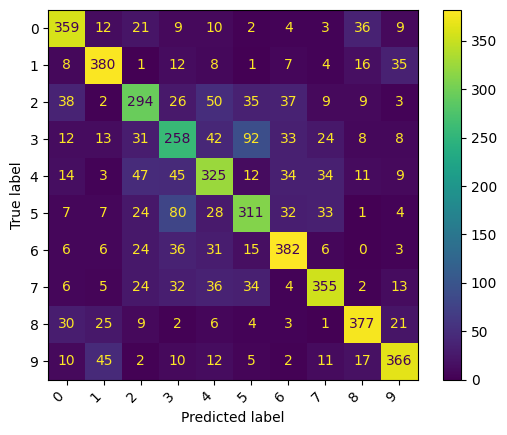

In [11]:
#confusion matrix for the validation set
color = 'white'
cm = confusion_matrix(y_valid, y_pred_valid)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.xticks(rotation=45, ha='right')
plt.show()